# ML - I : Case study 1 : Credit Card Application Approval Model

#### Learner: Prashant Bhide

## Dataset Reference

The data set has been taken from the following public S3 links:

1. __Credit card application__: This contains the demographic information of the users who are applying for the credit card.<br>https://s3.amazonaws.com/sqoop.oozie.ml/application_record.csv <br><br>

2. __Credit card performance__: This contains the performance of the users after they are issued the credit card. https://s3.amazonaws.com/sqoop.oozie.ml/credit_record.csv <br>


## Objectives

1. Perform EDA (Exploratory data analysis) to understand the data set and use well-considered visualisations to unwrap the insights.<br>
<br>
2. Perform any required checks such as variable exploration, outlier treatment, missing value imputation, variable transformation and correlation check.<br>
<br>
3. Apply the concepts of Weight of Evidence and Information Value to perform variable exploration and variable transformations.<br>
<br>
4. Once the data preprocessing is complete, build a credit card application approval model that predicts whether a customer's credit card is delinquent or not, solely based on the customer's application data. Use the credit card performance data to create the target variable, i.e., whether the customer's credit card is delinquent or not. The user ID will be classified as delinquent if the customer has ever delayed their payment by more than 60 days.<br>
<br>
5. Fine-tune the model and then evaluate the model by considering various metrics such as precision, recall, F1-score, AUC score and KS statistic.<br>

## Exploratory Data Analysis

### Preparing the development environment

#### Importing the common libraries

In [122]:
import os, sys, warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Defining the pyspark environment variables

In [3]:
# Definitions for EC2 Linux instance
# Here need to have same Python version on local machine and on worker node i.e. EC2. here both should have python3.
#os.environ["PYSPARK_PYTHON"] = "/bin/python3" (OR) "/usr/bin/python3"
#os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
#os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
#os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
#sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
#sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# Definitions for Windows 10 instance
os.environ["PYSPARK_PYTHON"] = "D:/Anaconda3/python"
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk1.8.0_251/jre"
os.environ["SPARK_HOME"] = "D:/spark-2.4.4-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "D:/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

#### Setting the global configuration options

In [5]:
warnings.filterwarnings('ignore')
pd.set_option('float_format', '{:.4f}'.format)
pd.options.display.max_colwidth = 100
plt.rcParams['font.size'] = '14'
MAX_MEMORY = '4g'
%matplotlib inline

### Welcome to this assignment
The following class has been written in Spark so that you can directly import this class and calculate the WOE and IV values for your dataframe. Few points to keep in mind are as follows:
1. For categorical variables, you can directly call this class and replace your variables with the WOE values
2. For continuous variables, you will have to first create monotonous bins such that the WOE values are monotonously increasing and then pass those column names into this class. 
3. To get the IV values, you can directly make use of the 'compute_iv' method which will return a dictionary containing all the IV values for each variable that was passed into this class

In [6]:
import math
from pyspark.sql import DataFrame
from pyspark.sql import functions as F

class WOE_IV(object):
    
    """
    This class contains methods that are used for calculating the WOE and IV values in a given dataset.
    
    Attributes
    ----------
    df : spark DataFrame (The spark dataframe)
    cols_to_woe : list (Columns that you want to convert in WOE and IV)
    label_column : str (target column of the data)
    good_label : str (Predicted variable in the form of 1 or 0)
    
    """
    
    def __init__(self, df: DataFrame, cols_to_woe: [str], label_column: str, good_label: str):
        self.df = df
        self.cols_to_woe = cols_to_woe
        self.label_column = label_column
        self.good_label = good_label
        self.fit_data = {} # This is a dictionary which will store all the WOE and IV computed in the latter part of the code

    def fit(self):  
        """
        This method takes the columns in 'cols_to_woe' and calculates the good and bad amounts,
        and then assigns the WOE values in the dictionary, 'fit_data'
        """
        for col_to_woe in self.cols_to_woe: # Iterating over each column in the list, cols_to_woe
            
            total_good = self.compute_total_amount_of_good() # Computes the total amount of good labels in the entire dataset
            total_bad = self.compute_total_amount_of_bad() # Computes the total amount of bad labels in the entire dataset
            
            woe_df = self.df.select(col_to_woe) # This dataframe stores the column, col_to_woe from the DataFrame
            categories = woe_df.distinct().collect() # Creates a list of all the distinct categories in the column, col_to_woe
            for category_row in categories: # Iterating over each category in the distinct categories of the column
                category = category_row[col_to_woe]
                
                # For each category, we calculate the good_amount and bad_amount
                good_amount = self.compute_good_amount(col_to_woe, category)
                bad_amount = self.compute_bad_amount(col_to_woe, category)
                
                # If the good_amount or bad_amount is 0, we replace it with 0.5, because in the calculation of woe, 
                # it comes in the denominator resulting in a Nan value which will give an error
                good_amount = good_amount if good_amount != 0 else 0.5
                bad_amount = bad_amount if bad_amount != 0 else 0.5

                # Calculating the fraction of good_amount and bad_amount specific to that category
                good_dist = good_amount / total_good
                bad_dist = bad_amount / total_bad

                # Calling the build_fit_data method which calculates the WOE and IV
                # for the category in the column and stores it in the dictionary, fit_data
                self.build_fit_data(col_to_woe, category, good_dist, bad_dist)

    def transform(self, df: DataFrame):
        """
        This method creates a column called "col_to_woe + '_woe'" which replaces the given category value with the WOE value.
        It finally returns a final dataframe containing the WOE values in place of the columns
        """
        def _encode_woe(col_to_woe_):
            return F.coalesce(
                *[F.when(F.col(col_to_woe_) == category, F.lit(woe_iv['woe']))
                  for category, woe_iv in self.fit_data[col_to_woe_].items()]
            )

        for col_to_woe, woe_info in self.fit_data.items():
            # Adds another column to the df containing the final WOE values
            df = df.withColumn(col_to_woe + '_woe', _encode_woe(col_to_woe))
        return df

    def compute_total_amount_of_good(self):
     # Computes the total amount of good labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) == self.good_label).count()

    def compute_total_amount_of_bad(self):
     # Computes the total amount of bad labels in the entire dataset
        return self.df.select(self.label_column).filter(F.col(self.label_column) != self.good_label).count()

    def compute_good_amount(self, col_to_woe: str, category: str):
     # Computes the total amount of good labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) == self.good_label)
                      ).count()

    def compute_bad_amount(self, col_to_woe: str, category: str):
        # Computes the total amount of bad labels for the specific class in the feature
        return self.df.select(col_to_woe, self.label_column)\
                      .filter(
                            (F.col(col_to_woe) == category) & (F.col(self.label_column) != self.good_label)
                      ).count()

    def build_fit_data(self, col_to_woe, category, good_dist, bad_dist):
        """
        Calculates the WOE and value for the specific category and saves it
        in the woe_info dictionary which is saved in the fit_data dictionary
                
        Attributes:
        col_to_woe: str (name of the feature)
        category: str (Class of that feature)
        good_dist: float (Fraction of good labels specific to that category)
        bad_dist: float (Fraction of bad labels specific to that category)
        
        """
        woe_info = {
            category: {
                'woe': math.log(good_dist / bad_dist), # Calculating the WOE value for the category in the column
                'iv': (good_dist - bad_dist) * math.log(good_dist / bad_dist) # Calc IV value for the category in the column
            }
        }

        # Adding the feature, col_to_woe to fit_data if not present already
        if col_to_woe not in self.fit_data:
            self.fit_data[col_to_woe] = woe_info
        else:
            self.fit_data[col_to_woe].update(woe_info)

    def compute_iv(self):
        """
        Returns the IV dictionary which contains the IV value for each feature
        """
        iv_dict = {}

        for woe_col, categories in self.fit_data.items():
            iv_dict[woe_col] = 0
            for category, woe_iv in categories.items():
                iv_dict[woe_col] += woe_iv['iv'] # IV for the feature = IV values for individual categories of feature (column)
        return iv_dict


#### Loading and analyzing the "application_record" dataset

In [7]:
df_application_record = pd.read_csv('https://s3.amazonaws.com/sqoop.oozie.ml/application_record.csv')
df_application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0000
1,5008805,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0000
2,5008806,M,Y,Y,0,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0000
3,5008808,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000
4,5008809,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000


In [8]:
df_application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [9]:
df_application_record.isna().sum() * 100.0 / df_application_record.shape[0]

ID                     0.0000
CODE_GENDER            0.0000
FLAG_OWN_CAR           0.0000
FLAG_OWN_REALTY        0.0000
CNT_CHILDREN           0.0000
AMT_INCOME_TOTAL       0.0000
NAME_INCOME_TYPE       0.0000
NAME_EDUCATION_TYPE    0.0000
NAME_FAMILY_STATUS     0.0000
NAME_HOUSING_TYPE      0.0000
DAYS_BIRTH             0.0000
DAYS_EMPLOYED          0.0000
FLAG_MOBIL             0.0000
FLAG_WORK_PHONE        0.0000
FLAG_PHONE             0.0000
FLAG_EMAIL             0.0000
OCCUPATION_TYPE       30.6010
CNT_FAM_MEMBERS        0.0000
dtype: float64

#### Missing value imputation

*Based on the null value counts, we see that the only feature with missing values is "OCCUPATION_TYPE" with a 30% missing rate. Since this feature can be expected to be closely related to "NAME_INCOME_TYPE", we will go ahead and impute the missing values with the most frequent value within each category as grouped by "NAME_INCOME_TYPE"*

In [17]:
df_application_record.OCCUPATION_TYPE.value_counts(dropna=False)

NaN                      134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

In [12]:
name_income_type_categories = df_application_record.NAME_INCOME_TYPE.value_counts()
name_income_type_categories

Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64

In [20]:
for category in name_income_type_categories.index:
    top_occupation = df_application_record[df_application_record.NAME_INCOME_TYPE==category]\
                    .OCCUPATION_TYPE.value_counts().index[0]
    print('Income Type =', category, '| Top Occupation =', top_occupation)
    df_application_record.loc[(df_application_record.NAME_INCOME_TYPE==category) & \
                              (df_application_record.OCCUPATION_TYPE.isna()), 'OCCUPATION_TYPE'] = top_occupation

Income Type = Working | Top Occupation = Laborers
Income Type = Commercial associate | Top Occupation = Laborers
Income Type = Pensioner | Top Occupation = Core staff
Income Type = State servant | Top Occupation = Core staff
Income Type = Student | Top Occupation = Core staff


In [21]:
df_application_record.OCCUPATION_TYPE.value_counts(dropna=False)

Laborers                 130871
Core staff               124579
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: OCCUPATION_TYPE, dtype: int64

#### Loading and analyzing the "credit_record" dataset

In [22]:
df_credit_record = pd.read_csv('https://s3.amazonaws.com/sqoop.oozie.ml/credit_record.csv')
df_credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [23]:
df_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [24]:
df_credit_record.isna().sum() * 100.0 / df_credit_record.shape[0]

ID               0.0000
MONTHS_BALANCE   0.0000
STATUS           0.0000
dtype: float64

#### Transforming the "credit_record" data into a "Delinquent Status" dataset
*Any user ID has to be classified as delinquent if that user has EVER delayed their payment by more than 60 days. From the Credit Application Data Dictionary, this condition can be mapped as the "STATUS" feature EVER having a value within the set(['2','3','4','5']). We will create a user-defined-function to check if the set of all "STATUS" values for each user ID has any overlap or intersection with the delinquent statuses and accordingly mark the final delinquent status for each user ID.*

In [25]:
delinquentStatuses = set(['2','3','4','5'])
funcGetDelinquentStatus = (lambda allStatuses: 1 if len(set(allStatuses).intersection(delinquentStatuses))>0 else 0) 
df_delinquent_status = df_credit_record.groupby('ID', as_index=False)[['STATUS']].agg(funcGetDelinquentStatus)
df_delinquent_status

,ID,STATUS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [26]:
print(df_delinquent_status.STATUS.value_counts(), '\n---\n', df_delinquent_status.STATUS.value_counts(normalize=True) * 100.00)

0    45318
1      667
Name: STATUS, dtype: int64 
---
 0   98.5495
1    1.4505
Name: STATUS, dtype: float64


#### Generating the "credit_issued" merged dataset 
*The "credit_issued" combined dataset will be generated with an inner join of the "Delinquent Status" and "application_record" datasets, since this is a Supervised Learning problem and we are only interested in user IDs that have the Delinquent label value already determined.*

In [28]:
df_creditcard_issued = pd.merge(df_delinquent_status, df_application_record, on=['ID'], how='inner')
df_creditcard_issued

,ID,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0000
1,5008805,0,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0000
2,5008806,0,M,Y,Y,0,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0000
3,5008808,0,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000
4,5008809,0,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5150482,0,F,Y,Y,1,157500.0000,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0000
36453,5150483,0,F,Y,Y,1,157500.0000,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0000
36454,5150484,0,F,Y,Y,1,157500.0000,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0000
36455,5150485,0,F,Y,Y,1,157500.0000,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3.0000


#### Duplicate data cleanup
*We can see that the merged dataset has many duplicate rows if we ignore the user ID column. Accordingly we will drop this ID column and then drop the duplicate rows from the merged dataset.*

In [29]:
df_creditcard_issued.drop(columns=['ID'], inplace=True)
df_creditcard_issued.drop_duplicates(inplace=True, ignore_index=True)
df_creditcard_issued

,STATUS,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,0,M,Y,Y,0,427500.0000,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Laborers,2.0000
1,0,M,Y,Y,0,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0000
2,0,F,N,Y,0,270000.0000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0000
3,0,F,N,Y,0,283500.0000,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,Core staff,1.0000
4,0,M,Y,Y,0,270000.0000,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,0,M,Y,Y,0,112500.0000,Working,Secondary / secondary special,Single / not married,House / apartment,-9874,-1650,1,1,0,0,Medicine staff,1.0000
9993,0,F,N,Y,1,135000.0000,Working,Secondary / secondary special,Married,House / apartment,-16302,-8894,1,0,0,0,Medicine staff,3.0000
9994,0,F,Y,Y,1,112500.0000,Working,Secondary / secondary special,Married,House / apartment,-14234,-309,1,0,0,0,Core staff,3.0000
9995,0,F,N,Y,0,180000.0000,Working,Secondary / secondary special,Married,House / apartment,-17713,-2441,1,0,0,0,Cooking staff,2.0000


In [30]:
print(df_creditcard_issued.STATUS.value_counts(), '\n---\n', df_creditcard_issued.STATUS.value_counts(normalize=True) * 100.00)

0    9555
1     442
Name: STATUS, dtype: int64 
---
 0   95.5787
1    4.4213
Name: STATUS, dtype: float64


__*We can see that the merged and de-duplicated dataset comes out to 9997 rows. The distribution of the Delinquent label within this dataset comes out to be 9555 "good" users and 442 "bad" users at a ratio of 95.58% good vs. 4.42% bad users.*__

#### As part of the EDA, report your observations for the following questions:

	1. What is the proportion of females in the applicant customer base?
	2. Is homeownership higher among male applicants or female applicants?
	3. Is there any correlation between the customer's income level and education level?
	4. What is the average and median salary of the applicant base?
	5. Is the proportion of bad customers higher for people who own cars?
	6. Is the proportion of bad customers higher for those living on rent than the rest of the population?
	7. Is the proportion of bad customers higher for those who are single than married customers?

#### EDA_1) What is the proportion of females in the applicant customer base?

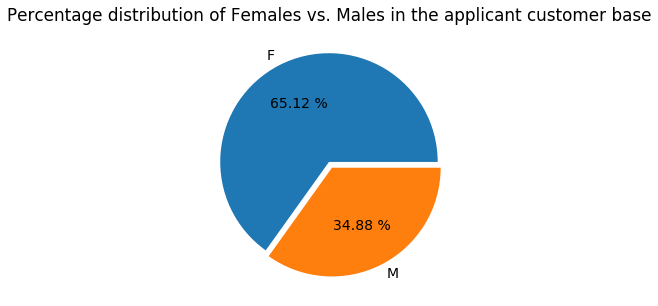

In [41]:
# Let us visualize the gender distribution as a pie plot

genderCounts = df_creditcard_issued.CODE_GENDER.value_counts()
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(5,5))
plt.pie(x=genderCounts, explode=[0.01,0.05], labels=genderCounts.index, autopct='%1.2f %%')
plt.title('Percentage distribution of Females vs. Males in the applicant customer base')
plt.show()

__*Observation: We can see that Females make up 65.12% of the applicant customer base compared to 34.88% Males*__

#### EDA_2) Is homeownership higher among male applicants or female applicants?

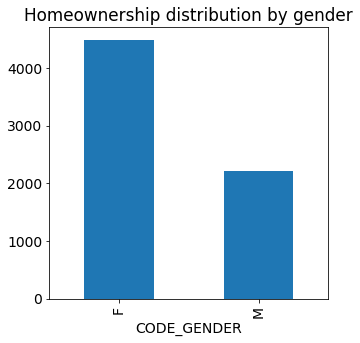

In [70]:
# Let us visualize the homeownership distribution as a bar plot

homeowner_gender_counts = df_creditcard_issued[df_creditcard_issued.FLAG_OWN_REALTY=='Y']\
                            .groupby('CODE_GENDER')['CODE_GENDER'].count()
plt.figure(figsize=(5,5))
homeowner_gender_counts.plot.bar()
plt.title('Homeownership distribution by gender')
plt.show()

__*Observation: We can see that homeownership is higher for female applicants compared to male applicants*__

#### EDA_3) Is there any correlation between the customer's income level and education level?

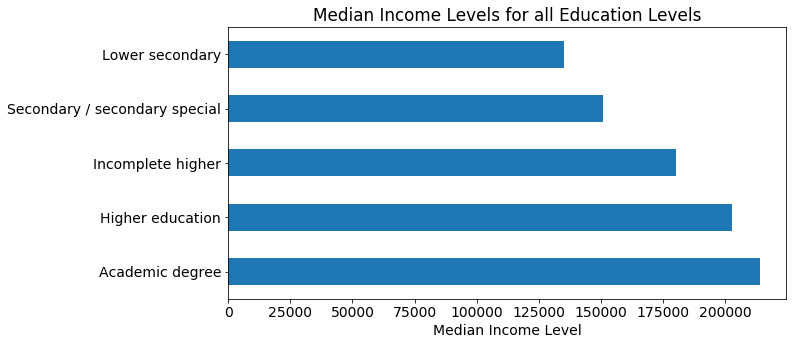

In [74]:
# Let us visualize the correlation between the customer's income level and education level as a horizontal bar plot

edulevel_vs_income = df_creditcard_issued.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL']\
                        .median().sort_values(ascending=False)
plt.figure(figsize=(10,5))
edulevel_vs_income.plot.barh()
plt.title('Median Income Levels for all Education Levels')
plt.xlabel('Median Income Level')
plt.ylabel(None)
plt.show()

__*Observation: We can see a direct correlation between the customer's income level and education level. Higher the education level, higher the median income for the overall applicant base*__

#### EDA_4) What is the average and median salary of the applicant base?

In [75]:
# Let us check the salary distribution statistics

df_creditcard_issued.AMT_INCOME_TOTAL.describe()

count      9997.0000
mean     181479.6474
std       99508.1045
min       27000.0000
25%      112500.0000
50%      157500.0000
75%      225000.0000
max     1575000.0000
Name: AMT_INCOME_TOTAL, dtype: float64

__*Observation: Based on the Income (salary) statistical distribution, we can see that the average (mean) salary of the applicant base comes to 181479.65, while the median (50th percentile) salary comes out to be 157500.00*__

#### EDA_5) Is the proportion of bad customers higher for people who own cars?

FLAG_OWN_CAR  STATUS
N             0         6036
              1          287
Y             0         3519
              1          155
Name: STATUS, dtype: int64

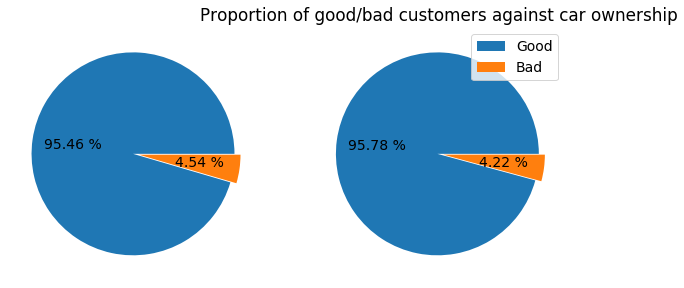

In [104]:
# Let us visualize the good/bad distribution against car ownership

carowner_delinquent_counts = df_creditcard_issued.groupby('FLAG_OWN_CAR')['STATUS'].value_counts()
display(carowner_delinquent_counts)
fig, ax = plt.subplots(figsize=(10, 6),ncols=2)
ax[0].pie(x=carowner_delinquent_counts[0:2], explode=[0.01,0.05], autopct='%1.2f %%')
ax[1].pie(x=carowner_delinquent_counts[2:4], explode=[0.01,0.05], autopct='%1.2f %%')
plt.title('Proportion of good/bad customers against car ownership')
plt.legend(['Good', 'Bad'])
plt.show()

__*Observation: We can see that the proportion of bad customers is higher for non-car-owners (bad is 4.54%) compared to car-owners (bad is 4.22%)*__

#### EDA_6) Is the proportion of bad customers higher for those living on rent than the rest of the population?

In [105]:
# Let us first create a new feature "FLAG_RENTER" with N/Y values to distinguish customers living on rent vs. the rest

df_creditcard_issued.NAME_HOUSING_TYPE.value_counts()

House / apartment      8941
With parents            457
Municipal apartment     334
Rented apartment        148
Office apartment         81
Co-op apartment          36
Name: NAME_HOUSING_TYPE, dtype: int64

In [106]:
df_creditcard_issued['FLAG_RENTER'] = df_creditcard_issued.NAME_HOUSING_TYPE\
                                        .apply(lambda x: 'Y' if x=='Rented apartment' else 'N')
df_creditcard_issued.FLAG_RENTER.value_counts()

N    9849
Y     148
Name: FLAG_RENTER, dtype: int64

FLAG_RENTER  STATUS
N            0         9414
             1          435
Y            0          141
             1            7
Name: STATUS, dtype: int64

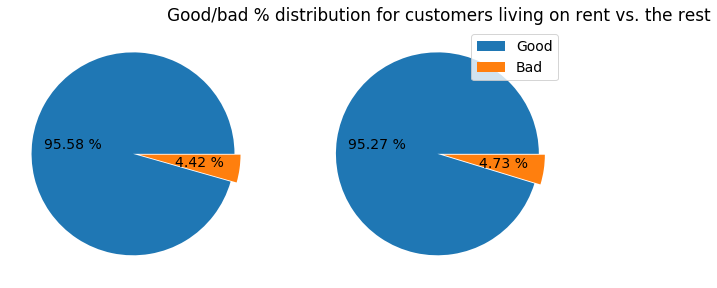

In [107]:
# Now we can visualize the good/bad % distribution for customers living on rent vs. the rest

rental_delinquent_counts = df_creditcard_issued.groupby('FLAG_RENTER')['STATUS'].value_counts()
display(rental_delinquent_counts)
fig, ax = plt.subplots(figsize=(10, 6),ncols=2)
ax[0].pie(x=rental_delinquent_counts[0:2], explode=[0.01,0.05], autopct='%1.2f %%')
ax[1].pie(x=rental_delinquent_counts[2:4], explode=[0.01,0.05], autopct='%1.2f %%')
plt.title('Good/bad % distribution for customers living on rent vs. the rest')
plt.legend(['Good', 'Bad'])
plt.show()

__*Observation: We can see that the proportion of bad customers is higher for renters (bad is 4.73%) compared to non-renters (bad is 4.42%)*__

#### EDA_7) Is the proportion of bad customers higher for those who are single than married customers?

In [108]:
# Let us first create a new feature "FLAG_SINGLE" with N/Y values to distinguish between single and married customers

df_creditcard_issued.NAME_FAMILY_STATUS.value_counts()

Married                 6728
Single / not married    1393
Civil marriage           859
Separated                587
Widow                    430
Name: NAME_FAMILY_STATUS, dtype: int64

In [110]:
df_creditcard_issued['FLAG_SINGLE'] = df_creditcard_issued.NAME_FAMILY_STATUS\
                                        .apply(lambda x: 'N' if (x=='Married' or x=='Civil marriage') else 'Y')
df_creditcard_issued.FLAG_SINGLE.value_counts()

N    7587
Y    2410
Name: FLAG_SINGLE, dtype: int64

FLAG_SINGLE  STATUS
N            0         7275
             1          312
Y            0         2280
             1          130
Name: STATUS, dtype: int64

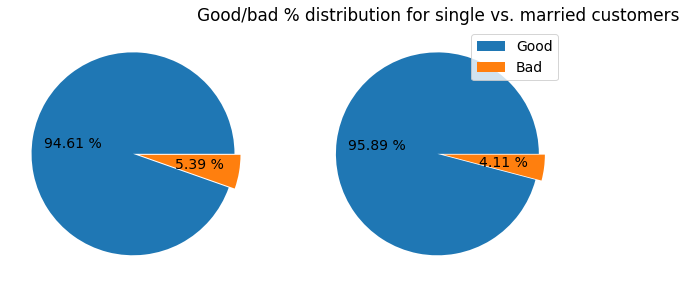

In [111]:
# Now we can visualize the good/bad % distribution for single and married customers

marital_delinquent_counts = df_creditcard_issued.groupby('FLAG_SINGLE')['STATUS'].value_counts()
display(marital_delinquent_counts)
fig, ax = plt.subplots(figsize=(10, 6),ncols=2)
ax[1].pie(x=marital_delinquent_counts[0:2], explode=[0.01,0.05], autopct='%1.2f %%')
ax[0].pie(x=marital_delinquent_counts[2:4], explode=[0.01,0.05], autopct='%1.2f %%')
plt.title('Good/bad % distribution for single vs. married customers')
plt.legend(['Good', 'Bad'])
plt.show()

__*Observation: We can see that the proportion of bad customers is higher for single (bad is 5.39%) compared to married (bad is 4.11%) customers*__

### Variable exploration and outlier treatment

In [112]:
df_backup1 = df_creditcard_issued
df_creditcard_issued.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   STATUS               9997 non-null   int64  
 1   CODE_GENDER          9997 non-null   object 
 2   FLAG_OWN_CAR         9997 non-null   object 
 3   FLAG_OWN_REALTY      9997 non-null   object 
 4   CNT_CHILDREN         9997 non-null   int64  
 5   AMT_INCOME_TOTAL     9997 non-null   float64
 6   NAME_INCOME_TYPE     9997 non-null   object 
 7   NAME_EDUCATION_TYPE  9997 non-null   object 
 8   NAME_FAMILY_STATUS   9997 non-null   object 
 9   NAME_HOUSING_TYPE    9997 non-null   object 
 10  DAYS_BIRTH           9997 non-null   int64  
 11  DAYS_EMPLOYED        9997 non-null   int64  
 12  FLAG_MOBIL           9997 non-null   int64  
 13  FLAG_WORK_PHONE      9997 non-null   int64  
 14  FLAG_PHONE           9997 non-null   int64  
 15  FLAG_EMAIL           9997 non-null   i

In [113]:
# Let us check the statistical summary for all the numeric features

df_creditcard_issued.describe()

,STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000
mean,0.0442,0.4234,181479.6474,-15985.9679,61541.3035,1.0000,0.2189,0.2885,0.0878,2.1835
std,0.2056,0.7670,99508.1045,4244.0316,139486.8333,0.0000,0.4135,0.4531,0.2831,0.9334
min,0.0000,0.0000,27000.0000,-25152.0000,-15713.0000,1.0000,0.0000,0.0000,0.0000,1.0000
25%,0.0000,0.0000,112500.0000,-19538.0000,-2992.0000,1.0000,0.0000,0.0000,0.0000,2.0000
50%,0.0000,0.0000,157500.0000,-15615.0000,-1373.0000,1.0000,0.0000,0.0000,0.0000,2.0000
75%,0.0000,1.0000,225000.0000,-12423.0000,-339.0000,1.0000,0.0000,1.0000,0.0000,3.0000
max,1.0000,19.0000,1575000.0000,-7489.0000,365243.0000,1.0000,1.0000,1.0000,1.0000,20.0000


__*We can see that all the numeric features show a proper progression from min to max values except for the "DAYS_EMPLOYED" feature includes significant outliers going by the difference between the 75th percentile and max values. Any such invalid (positive values will be invalid as per the data dictionary) outliers will be converted to null and then imputed with the median value for this feature*__

In [115]:
df_creditcard_issued[df_creditcard_issued.DAYS_EMPLOYED>0]['DAYS_EMPLOYED'].value_counts()

365243    1741
Name: DAYS_EMPLOYED, dtype: int64

In [117]:
df_creditcard_issued['DAYS_EMPLOYED'] = df_creditcard_issued['DAYS_EMPLOYED'].apply(lambda x: np.NaN if x>0 else x)

In [118]:
df_creditcard_issued['DAYS_EMPLOYED'].fillna(df_creditcard_issued['DAYS_EMPLOYED'].median(), inplace=True)

In [121]:
# Let us now check the categorial ('object' type) features value counts

for colname in df_creditcard_issued.columns:
    if (df_creditcard_issued[colname].dtype=='object'):
        print(df_creditcard_issued[colname].value_counts(dropna=False))
        print('----------')

F    6510
M    3487
Name: CODE_GENDER, dtype: int64
----------
N    6323
Y    3674
Name: FLAG_OWN_CAR, dtype: int64
----------
Y    6693
N    3304
Name: FLAG_OWN_REALTY, dtype: int64
----------
Working                 5109
Commercial associate    2381
Pensioner               1757
State servant            747
Student                    3
Name: NAME_INCOME_TYPE, dtype: int64
----------
Secondary / secondary special    6949
Higher education                 2539
Incomplete higher                 384
Lower secondary                   119
Academic degree                     6
Name: NAME_EDUCATION_TYPE, dtype: int64
----------
Married                 6728
Single / not married    1393
Civil marriage           859
Separated                587
Widow                    430
Name: NAME_FAMILY_STATUS, dtype: int64
----------
House / apartment      8941
With parents            457
Municipal apartment     334
Rented apartment        148
Office apartment         81
Co-op apartment          36
Name: NAM

### Variable transformation and correlation check

In [123]:
# Let us convert all the Y/N value categorical features to 1/0 numeric features

df_backup2 = df_creditcard_issued
df_creditcard_issued['FLAG_OWN_CAR'] = df_creditcard_issued['FLAG_OWN_CAR'].apply(lambda x: 1 if x=='Y' else 0)
df_creditcard_issued['FLAG_OWN_REALTY'] = df_creditcard_issued['FLAG_OWN_REALTY'].apply(lambda x: 1 if x=='Y' else 0)

In [124]:
# Let us convert the CODE_GENDER 'F'/'M' feature to a new FLAG_MALE feature with 0/1 values standing for 0=='F' and 1=='M'

df_creditcard_issued['FLAG_MALE'] = df_creditcard_issued['CODE_GENDER'].apply(lambda x: 1 if x=='M' else 0)

In [126]:
# Let us now drop all the converted (CODE_GENDER), non-discriminatory (FLAG_MOBIL which has all values as '1')
# and extra features (FLAG_RENTER and 'FLAG_SINGLE) created during the EDA

df_creditcard_issued.drop(columns=['CODE_GENDER', 'FLAG_MOBIL', 'FLAG_RENTER', 'FLAG_SINGLE'], inplace=True)

In [133]:
# Let us convert the CNT_FAM_MEMBERS feature from float to int dtype

df_creditcard_issued['CNT_FAM_MEMBERS'] = df_creditcard_issued['CNT_FAM_MEMBERS'].astype(int)

In [130]:
df_creditcard_issued.describe()

,STATUS,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,FLAG_MALE
count,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000,9997.0000
mean,0.0442,0.3675,0.6695,0.4234,181479.6474,-15985.9679,-2379.8851,0.2189,0.2885,0.0878,2.1835,0.3488
std,0.2056,0.4822,0.4704,0.7670,99508.1045,4244.0316,2127.5785,0.4135,0.4531,0.2831,0.9334,0.4766
min,0.0000,0.0000,0.0000,0.0000,27000.0000,-25152.0000,-15713.0000,0.0000,0.0000,0.0000,1.0000,0.0000
25%,0.0000,0.0000,0.0000,0.0000,112500.0000,-19538.0000,-2992.0000,0.0000,0.0000,0.0000,2.0000,0.0000
50%,0.0000,0.0000,1.0000,0.0000,157500.0000,-15615.0000,-1799.0000,0.0000,0.0000,0.0000,2.0000,0.0000
75%,0.0000,1.0000,1.0000,1.0000,225000.0000,-12423.0000,-1037.0000,0.0000,1.0000,0.0000,3.0000,1.0000
max,1.0000,1.0000,1.0000,19.0000,1575000.0000,-7489.0000,-17.0000,1.0000,1.0000,1.0000,20.0000,1.0000


In [131]:
df_creditcard_issued.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   STATUS               9997 non-null   int64  
 1   FLAG_OWN_CAR         9997 non-null   int64  
 2   FLAG_OWN_REALTY      9997 non-null   int64  
 3   CNT_CHILDREN         9997 non-null   int64  
 4   AMT_INCOME_TOTAL     9997 non-null   float64
 5   NAME_INCOME_TYPE     9997 non-null   object 
 6   NAME_EDUCATION_TYPE  9997 non-null   object 
 7   NAME_FAMILY_STATUS   9997 non-null   object 
 8   NAME_HOUSING_TYPE    9997 non-null   object 
 9   DAYS_BIRTH           9997 non-null   int64  
 10  DAYS_EMPLOYED        9997 non-null   float64
 11  FLAG_WORK_PHONE      9997 non-null   int64  
 12  FLAG_PHONE           9997 non-null   int64  
 13  FLAG_EMAIL           9997 non-null   int64  
 14  OCCUPATION_TYPE      9997 non-null   object 
 15  CNT_FAM_MEMBERS      9997 non-null   i

__*We will now convert the continuous numeric value features into ordinal categorical features for subsequent "Weight of Evidence" transformations. We will use pandas quantile binning (10% x 10 chunks) which will automatically coerce any outliers into the first or last bin respective groups*__

In [134]:
df_creditcard_issued['AGE_CATEGORY'] = pd.qcut(x=(df_creditcard_issued['DAYS_BIRTH']/(-365.0)),\
                                        q=10, labels=[0,1,2,3,4,5,6,7,8,9])
print(df_creditcard_issued['AGE_CATEGORY'].value_counts())

0    1006
9    1000
8    1000
6    1000
4    1000
3    1000
7     999
5     999
2     999
1     994
Name: AGE_CATEGORY, dtype: int64


In [136]:
df_creditcard_issued['EMPLOYED_CATEGORY'] = pd.qcut(x=(df_creditcard_issued['DAYS_EMPLOYED'] / (-365.0)),\
                                             q=10, labels=[0,1,2,3,4,5,6,7,8,9], duplicates='drop')
print(df_creditcard_issued['EMPLOYED_CATEGORY'].value_counts())

4    1871
1    1005
6    1001
0    1001
9    1000
8    1000
2     999
7     997
3     996
5     127
Name: EMPLOYED_CATEGORY, dtype: int64


In [137]:
df_creditcard_issued['INCOME_CATEGORY'] = pd.qcut(x=df_creditcard_issued['AMT_INCOME_TOTAL'], \
                                            q=10, labels=[0,1,2,3,4,5,6,7,8,9], duplicates='drop')
print(df_creditcard_issued['INCOME_CATEGORY'].value_counts())

0    1400
1    1199
3    1182
4    1108
5    1107
8     994
9     954
7     922
6     718
2     413
Name: INCOME_CATEGORY, dtype: int64


In [140]:
# Let us validate the remaining continuous numeric features

print(df_creditcard_issued.CNT_CHILDREN.value_counts())
print(df_creditcard_issued.CNT_FAM_MEMBERS.value_counts())

0     7019
1     1942
2      877
3      132
4       19
5        5
7        1
14       1
19       1
Name: CNT_CHILDREN, dtype: int64
2     5333
1     2005
3     1684
4      826
5      123
6       19
7        4
15       1
20       1
9        1
Name: CNT_FAM_MEMBERS, dtype: int64


In [142]:
# Let us now drop all the converted features from the dataset

df_creditcard_issued.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL'], inplace=True)

In [143]:
df_creditcard_issued.head()

,STATUS,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,FLAG_MALE,AGE_CATEGORY,EMPLOYED_CATEGORY,INCOME_CATEGORY
0,0,1,1,0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Laborers,2,1,2,8,9
1,0,1,1,0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,1,8,2,1
2,0,0,1,0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,0,7,7,8
3,0,0,1,0,Pensioner,Higher education,Separated,House / apartment,0,0,0,Core staff,1,0,9,4,8
4,0,1,1,0,Working,Higher education,Married,House / apartment,1,1,1,Accountants,2,1,5,1,8


#### Correlation check

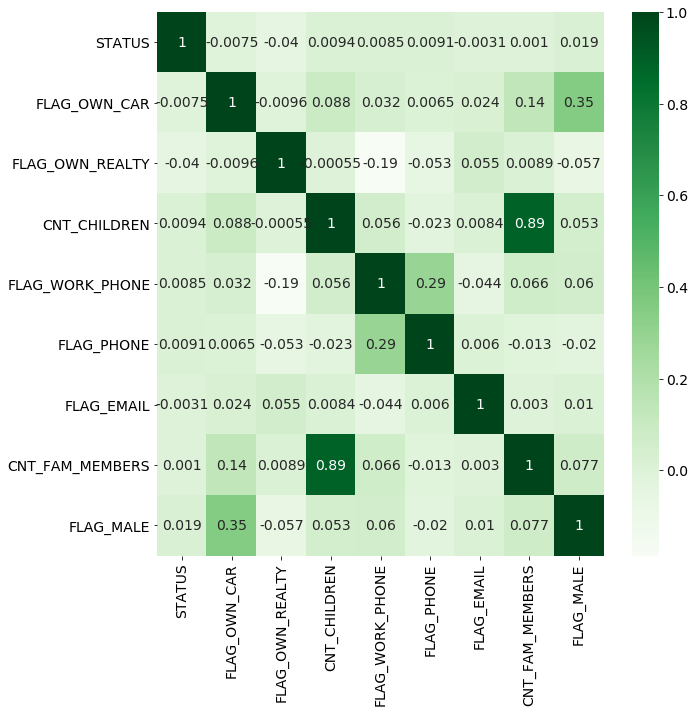

In [146]:
# Let us view a correlation matrix of all the numeric features as a heatmap plot

plt.figure(figsize=(10,10))
sns.heatmap(df_creditcard_issued.corr(), cmap='Greens', annot=True)
plt.show()

__*We can see that the feature "CNT_CHILDREN" is highly correlated with "CNT_FAM_MEMBERS". Accordingly we will go ahead and drop feature "CNT_CHILDREN" from the dataset*__

In [147]:
df_creditcard_issued.drop(columns=['CNT_CHILDREN'], inplace=True)

### Feature Selection and Model Building

In [148]:
# Creating Spark Session

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("CreditApprovalAssignment") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [150]:
df_credit_spark1 = spark.createDataFrame(df_creditcard_issued)
df_credit_spark1.show(2,truncate=False)

+------+------------+---------------+----------------+-----------------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+---------+------------+-----------------+---------------+
|STATUS|FLAG_OWN_CAR|FLAG_OWN_REALTY|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE          |NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|FLAG_MALE|AGE_CATEGORY|EMPLOYED_CATEGORY|INCOME_CATEGORY|
+------+------------+---------------+----------------+-----------------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+---------+------------+-----------------+---------------+
|0     |1           |1              |Working         |Higher education             |Civil marriage    |Rented apartment |1              |0         |0         |Laborers       |2              |1        |2           |8                |9              |
|0  

#### Applying the concepts of Weight of Evidence and Information Value to perform variable exploration and variable transformations

In [151]:
# We will leverage the WOE_IV class defined earlier to calculate the Weight of Evidence and Information Value figures

cols_to_woe = ['FLAG_MALE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',\
               'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',\
               'AGE_CATEGORY', 'EMPLOYED_CATEGORY', 'INCOME_CATEGORY', 'CNT_FAM_MEMBERS']
label_column = 'STATUS'
good_label = '0'

woe = WOE_IV(df_credit_spark1, cols_to_woe, label_column, good_label)
woe.fit()
dict_IV = woe.compute_iv()

In [152]:
# We will use the calculated Information Value figures with a minimum threshold of 0.002 to determine the predictor variables

for key,val in dict_IV.items():
    print(key,':',val,('==> FEATURE SELECTED' if val > 0.002 else '==> WEAK predictor, IGNORE'))

FLAG_MALE : 0.008537770823934717 ==> FEATURE SELECTED
FLAG_OWN_CAR : 0.0013470407039887144 ==> WEAK predictor, IGNORE
FLAG_OWN_REALTY : 0.03645194403569873 ==> FEATURE SELECTED
FLAG_WORK_PHONE : 0.0016859210799422967 ==> WEAK predictor, IGNORE
FLAG_PHONE : 0.0019320143952654633 ==> WEAK predictor, IGNORE
FLAG_EMAIL : 0.00023630860422097378 ==> WEAK predictor, IGNORE
NAME_INCOME_TYPE : 0.015740641785341465 ==> FEATURE SELECTED
NAME_EDUCATION_TYPE : 0.006773527817697774 ==> FEATURE SELECTED
NAME_FAMILY_STATUS : 0.02746591464178003 ==> FEATURE SELECTED
NAME_HOUSING_TYPE : 0.013305220534010755 ==> FEATURE SELECTED
OCCUPATION_TYPE : 0.04421821977679071 ==> FEATURE SELECTED
AGE_CATEGORY : 0.034680485126883306 ==> FEATURE SELECTED
EMPLOYED_CATEGORY : 0.012943477988914445 ==> FEATURE SELECTED
INCOME_CATEGORY : 0.015487653189263734 ==> FEATURE SELECTED
CNT_FAM_MEMBERS : 0.020178391423001003 ==> FEATURE SELECTED


In [153]:
df_credit_spark2 = woe.transform(df_credit_spark1)
df_credit_spark2.printSchema()

root
 |-- STATUS: long (nullable = true)
 |-- FLAG_OWN_CAR: long (nullable = true)
 |-- FLAG_OWN_REALTY: long (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- FLAG_WORK_PHONE: long (nullable = true)
 |-- FLAG_PHONE: long (nullable = true)
 |-- FLAG_EMAIL: long (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: long (nullable = true)
 |-- FLAG_MALE: long (nullable = true)
 |-- AGE_CATEGORY: long (nullable = true)
 |-- EMPLOYED_CATEGORY: long (nullable = true)
 |-- INCOME_CATEGORY: long (nullable = true)
 |-- FLAG_MALE_woe: double (nullable = true)
 |-- FLAG_OWN_CAR_woe: double (nullable = true)
 |-- FLAG_OWN_REALTY_woe: double (nullable = true)
 |-- FLAG_WORK_PHONE_woe: double (nullable = true)
 |-- FLAG_PHONE_woe: double (nullable = true)
 |-- FLAG_EMAIL_woe: double (nullable = tru

In [155]:
df_credit_spark2.show(2,truncate=False)

+------+------------+---------------+----------------+-----------------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+---------+------------+-----------------+---------------+-------------------+-------------------+-------------------+--------------------+-------------------+---------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+---------------------+---------------------+-------------------+-------------------+
|STATUS|FLAG_OWN_CAR|FLAG_OWN_REALTY|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE          |NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|FLAG_MALE|AGE_CATEGORY|EMPLOYED_CATEGORY|INCOME_CATEGORY|FLAG_MALE_woe      |FLAG_OWN_CAR_woe   |FLAG_OWN_REALTY_woe|FLAG_WORK_PHONE_woe |FLAG_PHONE_woe     |FLAG_EMAIL_woe       |NAME_INCOME_TYPE_woe|NAME_EDUCATION_TYPE_woe|NAME_FAMILY_STATU

### Building the LogisticRegression Model and Evaluation

In [157]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [158]:
# We will select the **_woe encoded variables that passed the IV threshold of 0.002 as the "features" set for training

#FLAG_MALE : 0.008537770823934717 ==> FEATURE SELECTED
#FLAG_OWN_REALTY : 0.03645194403569873 ==> FEATURE SELECTED
#NAME_INCOME_TYPE : 0.015740641785341465 ==> FEATURE SELECTED
#NAME_EDUCATION_TYPE : 0.006773527817697774 ==> FEATURE SELECTED
#NAME_FAMILY_STATUS : 0.02746591464178003 ==> FEATURE SELECTED
#NAME_HOUSING_TYPE : 0.013305220534010755 ==> FEATURE SELECTED
#OCCUPATION_TYPE : 0.04421821977679071 ==> FEATURE SELECTED
#AGE_CATEGORY : 0.034680485126883306 ==> FEATURE SELECTED
#EMPLOYED_CATEGORY : 0.012943477988914445 ==> FEATURE SELECTED
#INCOME_CATEGORY : 0.015487653189263734 ==> FEATURE SELECTED
#CNT_FAM_MEMBERS : 0.020178391423001003 ==> FEATURE SELECTED

trainCols = ['FLAG_MALE_woe', 'FLAG_OWN_REALTY_woe', 'NAME_INCOME_TYPE_woe', 'NAME_EDUCATION_TYPE_woe',\
             'NAME_FAMILY_STATUS_woe', 'NAME_HOUSING_TYPE_woe', 'OCCUPATION_TYPE_woe', 'AGE_CATEGORY_woe',\
             'EMPLOYED_CATEGORY_woe', 'INCOME_CATEGORY_woe', 'CNT_FAM_MEMBERS_woe']

assembler = VectorAssembler(inputCols=trainCols, outputCol='features')
df_credit_master1 = assembler.transform(df_credit_spark2)
df_credit_master1.show(2, truncate=False)

+------+------------+---------------+----------------+-----------------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+---------+------------+-----------------+---------------+-------------------+-------------------+-------------------+--------------------+-------------------+---------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+---------------------+---------------------+-------------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|STATUS|FLAG_OWN_CAR|FLAG_OWN_REALTY|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE          |NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|FLAG_MALE|AGE_CATE

#### Using a Train-Test split of 70:30 and a Seed value of 2018 (as specified in the Evaluation Rubrics)

In [159]:
train_data, test_data = df_credit_master1.randomSplit(weights=[0.7,0.3], seed=2018)
print('Train data count =', train_data.count(), '| Test data count =', test_data.count())

Train data count = 6953 | Test data count = 3044


In [160]:
lr1 = LogisticRegression(featuresCol='features', labelCol='STATUS', maxIter=10)
model1 = lr1.fit(train_data)
result1 = model1.evaluate(test_data)
print('Result1: RecallByLabel =', result1.recallByLabel, '| PrecisionByLabel =', result1.precisionByLabel)

Result1: RecallByLabel = [1.0, 0.0] | PrecisionByLabel = [0.9510512483574245, 0.0]


__*We can see that the Recall for positive class (1 == DELINQUENT) is 0.0 which indicates that the trained model is unable to predict any True Positives. We already know that this is a highly unbalanced dataset with a Negative:Positive class ratio of roughly 96%:4%. Accordingly, we will attempt the concept of "Weight of Class" to re-train the model by specifying weights in the inverse ratio for the Negative and Positive classes*__

In [161]:
from pyspark.sql.functions import col, when

df_credit_master1 = df_credit_master1.withColumn('WEIGHT_OF_CLASS', when(col('STATUS')==1, 0.96).otherwise(0.04))
df_credit_master1.show(2, truncate=False)

+------+------------+---------------+----------------+-----------------------------+------------------+-----------------+---------------+----------+----------+---------------+---------------+---------+------------+-----------------+---------------+-------------------+-------------------+-------------------+--------------------+-------------------+---------------------+--------------------+-----------------------+----------------------+---------------------+--------------------+---------------------+---------------------+-------------------+-------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|STATUS|FLAG_OWN_CAR|FLAG_OWN_REALTY|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE          |NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|FL

In [162]:
train_data, test_data = df_credit_master1.randomSplit(weights=[0.7,0.3], seed=2018)
print('Train data count =', train_data.count(), '| Test data count =', test_data.count())

lr2 = LogisticRegression(featuresCol='features', labelCol='STATUS', maxIter=10, weightCol='WEIGHT_OF_CLASS')
model2 = lr2.fit(train_data)
result2 = model2.evaluate(test_data)
print('Result2: RecallByLabel =', result2.recallByLabel, '| PrecisionByLabel =', result2.precisionByLabel)

Train data count = 6953 | Test data count = 3044
Result2: RecallByLabel = [0.5637305699481865, 0.6174496644295302] | PrecisionByLabel = [0.9662522202486679, 0.06789667896678966]


__*We can see that the Recall for positive class (1 == DELINQUENT) has significantly improved to 0.617 along with Precision at 0.067 after re-training the model with the "Weight of Class" hyperparameter tuning !!!*__

In [163]:
# Let us check the accuracy and AreaUnderROC metrics as well

print('Result2: Accuracy =', result2.accuracy, '| AreaUnderROC =', result2.areaUnderROC)

Result2: Accuracy = 0.5663600525624178 | AreaUnderROC = 0.6064332162603887


In [168]:
# Let us calculate the F1 scope from Precision and Recall values

Precision = 0.06789667896678966 # from above result
Recall = 0.6174496644295302 # from above result
F1_score = (2 * Precision * Recall) / (Precision + Recall)
print('F1_score =', F1_score)

F1_score = 0.12234042553191489


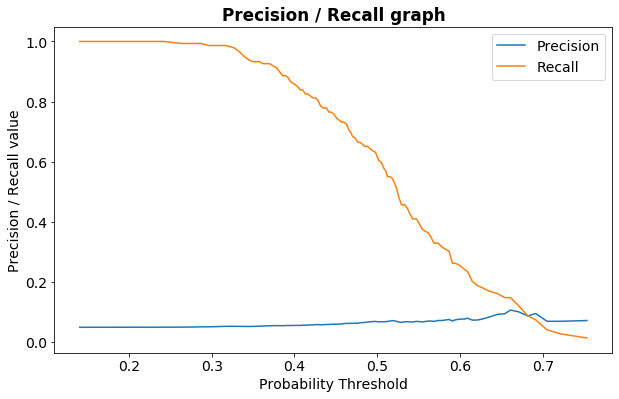

In [167]:
# Let us visualize the Precision-Recall graph for the predicted results

rbt2 = result2.recallByThreshold.toPandas()
pbt2 = result2.precisionByThreshold.toPandas()

plt.figure(figsize=(10,6))
plt.title(label='Precision / Recall graph', fontdict=dict(fontweight='bold'))
plt.plot('threshold', 'precision', data=pbt2)
plt.plot('threshold', 'recall', data=rbt2)
plt.legend(['Precision', 'Recall'])
plt.xlabel('Probability Threshold')
plt.ylabel('Precision / Recall value')
plt.show()

#### KS statistic analysis

In [171]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

extractNegProb = udf(lambda v:float(v[0]),FloatType())
extractPosProb = udf(lambda v:float(v[1]),FloatType())

df_predictions2 = result2.predictions.select(col('STATUS'), \
                    extractNegProb(col('probability')).alias('neg_class_prob'),\
                    extractPosProb(col('probability')).alias('pos_class_prob'),\
                    'prediction')
df_predictions2.show(2, truncate=False)

+------+--------------+--------------+----------+
|STATUS|neg_class_prob|pos_class_prob|prediction|
+------+--------------+--------------+----------+
|0     |0.28386682    |0.7161332     |1.0       |
|0     |0.5289499     |0.47105008    |0.0       |
+------+--------------+--------------+----------+
only showing top 2 rows



In [172]:
pd_predictions2 = df_predictions2.toPandas()

from scipy.stats import ks_2samp
ks_2samp(pd_predictions2.loc[pd_predictions2.STATUS==0,'neg_class_prob'],\
         pd_predictions2.loc[pd_predictions2.STATUS==1,'pos_class_prob'])

Ks_2sampResult(statistic=0.06610564384323817, pvalue=0.5422850988306829)

#### Evaluation metrics for Model trained with "Weight of Class" tuning :
1. Precision = 0.06789667896678966<br>
2. Recall = 0.6174496644295302<br>
3. F1_score = 0.12234042553191489<br>
4. AreaUnderROC = 0.6064332162603887<br>
4. KS_statistic = 0.06610564384323817<br>